In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import seaborn as sns
import gc
from tqdm import tqdm
from warnings import filterwarnings
filterwarnings('ignore')

%matplotlib inline

PATH = '../../'

In [2]:
%%time
train = pd.read_csv(PATH + 'train.csv')
test = pd.read_csv(PATH + 'Track 1/test.csv')
submission = pd.read_csv(PATH + 'Track 1/submission.csv')

Wall time: 2.96 s


### LB Score Calc

Для подсчета скора просто используйте функцию getLBScore

In [3]:
def smape(satellite_predicted_values, satellite_true_values): 
    # the division, addition and subtraction are pointwise 
    return np.mean(np.abs(satellite_predicted_values - satellite_true_values) / (np.abs(satellite_predicted_values) + np.abs(satellite_true_values)))

### Model training

In [4]:
training_columns = ['epoch', 'sat_id', 'x_sim', 'y_sim', 'z_sim', 'Vx_sim', 'Vy_sim', 'Vz_sim']
prediction_columns = ['x','y','z','Vx', 'Vy', 'Vz']
X = train.loc[:, training_columns]
y = train.loc[:, prediction_columns]
Xtest = test.loc[:, training_columns]

In [5]:
X.drop(columns = 'epoch', inplace = True)
Xtest.drop(columns = 'epoch', inplace = True)

In [6]:
X['r'] = np.sqrt(X.x_sim**2 + X.y_sim**2 + X.z_sim**2)
Xtest['r'] = np.sqrt(Xtest.x_sim**2 + Xtest.y_sim**2 + Xtest.z_sim**2)

X['phi'] = np.arctan(X.y_sim/X.x_sim)
Xtest['phi'] = np.arctan(Xtest.y_sim/Xtest.x_sim)

X['theta'] = np.arccos(X.z_sim/X.r)
Xtest['theta'] = np.arccos(Xtest.z_sim/Xtest.r)



X['Vr'] = np.sqrt(X.Vx_sim**2 + X.Vy_sim**2 + X.Vz_sim**2)
Xtest['Vr'] = np.sqrt(Xtest.Vx_sim**2 + Xtest.Vy_sim**2 + Xtest.Vz_sim**2)

X['Vphi'] = np.arctan(X.Vy_sim/X.Vx_sim)
Xtest['Vphi'] = np.arctan(Xtest.Vy_sim/Xtest.Vx_sim)

X['Vtheta'] = np.arccos(X.Vz_sim/X.Vr)
Xtest['Vtheta'] = np.arccos(Xtest.Vz_sim/Xtest.Vr)

Train 0 Final 90.23705811666215
Train 1 Final 90.86420235739769
Train 2 Final 91.64374603486691
Train 3 Final 92.54201878479094
Mean fold LB score 91.32175632342941


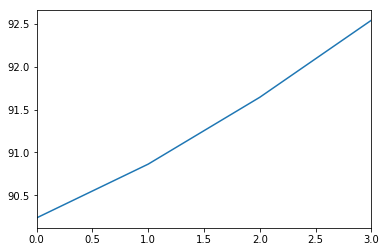

In [7]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler
model = Ridge(alpha=0.01)
scores = []
shift = 0.1
trainSize = 0.6
mult = 2
sc = StandardScaler()
times = np.arange(0, 1-(mult-1)*trainSize, shift)
for sz,_ in enumerate(times):
    submissionValid = train.copy()[['id', 'sat_id', 'x', 'y', 'z', 'Vx', 'Vy', 'Vz']]
    smp = []
    SMP = []
    nTargets = 6
    for sat_id in X['sat_id'].unique():
        if sat_id >= 0:
            smp = []
            satX = X[X['sat_id'] == sat_id]
            satX = pd.concat([satX, satX.shift(1).fillna(0),
                             satX.shift(2).fillna(0),
                             satX.shift(3).fillna(0),
                             satX.shift(4).fillna(0)], axis = 1)
            satY = y[X['sat_id'] == sat_id]
            start = int(sz*(satX.shape[0] * shift))
            size = int(satX.shape[0] * trainSize)
            Xtr, Xval = satX.iloc[start:start+size, :], satX.iloc[start+size:, :]
            ytr, yval = satY.iloc[start:start+size, :], satY.iloc[start+size:, :]
            for i in range(nTargets):
                model.fit(Xtr, ytr.iloc[:, i])
                ypred = model.predict(Xval)
                smp.append(smape(ypred, yval.iloc[:, i]))
                SMP.append(smape(ypred, yval.iloc[:, i]))
    print(f'Train {sz} Final', 100*(1- np.mean(SMP)))
    scores.append(100*(1- np.mean(SMP)))
print(f'Mean fold LB score {np.mean(scores)}')
pd.Series(scores).plot()

In [141]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import AdaBoostRegressor
model = LinearRegression()
nTargets = 6
for sat_id in tqdm(Xtest['sat_id'].unique()):
    satX = X[X['sat_id'] == sat_id].drop(columns = ['sat_id'])
    satX = pd.concat([satX, satX.shift(1).fillna(0), 
                  satX.shift(2).fillna(0), satX.shift(3).fillna(0),
                 satX.shift(4).fillna(0),
                     satX.shift(5).fillna(0),
                     satX.shift(6).fillna(0)], axis = 1)
    satY = y[X['sat_id'] == sat_id]
    satXtest = Xtest[Xtest['sat_id'] == sat_id].drop(columns = ['sat_id'])
    satXtest = pd.concat([satXtest, satXtest.shift(1).fillna(0),satXtest.shift(2).fillna(0), satXtest.shift(3).fillna(0),
                         satXtest.shift(4).fillna(0),
                         satXtest.shift(5).fillna(0),
                         satXtest.shift(6).fillna(0)], axis = 1)
    
    for i in range(nTargets):
        model.fit(satX, satY.iloc[:, i])
        ypred = model.predict(satXtest)
        submission.loc[satXtest.index, submission.columns[i+1]] = ypred

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:14<00:00, 18.01it/s]


In [143]:
submission.to_csv('submission.csv', index = None)